# Bootstrap estimation

Ce notebook contient le code qui explique comment Python nous aide à comprendre la statistique.

### Notebook setup

In [1]:
# Install stats library
%pip install --quiet ministats 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Figures setup
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()  # needed otherwise `sns.set_theme` doesn't work
sns.set_theme(
    style="whitegrid",
    rc={'figure.figsize': (4, 3)},
)
# High-resolution figures please
%config InlineBackend.figure_format = 'retina'

def savefig(fig, filename, **kwargs):
    fig.tight_layout(**kwargs)
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)

# simple float __repr__
import numpy as np
np.set_printoptions(legacy='1.25')

<Figure size 640x480 with 0 Axes>

## Introduction

Dans ce notebook, je vais vous introduire à quelques concepts statistiques fondamentaux d'un point de vue computationnel. En écrivant du code Python simple (genre des `for`-loop), on peut comprendre certains concepts fondamentaux des statistiques. Si vous n'êtes pas familier avec Python, je vous recommande de lire d'abord le blog post [Python coding skills for statistic](https://minireference.com/blog/python-for-stats/) (en angalis) et le notebook qui vient avec [python_for_stats.ipynb](./python_for_stats.ipynb).

**TL;DR** L'approche computationnelle pour les calculs statistiques simplifie grandement l'apprentissage des concepts, contrairement à l'enseignement classique basé sur des formules et procédures à mémoriser. 


Les exemples d'analyses statistiques de ce cahier sont tirés du livre [No Bullshit Guide to Statistics](https://noBSstats.com/), que vous pouvez consulter pour en savoir plus sur les statistiques.


### La statistique classique

Les techniques de la statistique « classique » ont été développées dans le temps où les capacités de calcul étaient limitées (le monde avait pas encore accès à des ordis dans leur poches, dans leur sacs, et dans le cloud). Les statisticiens ont donc développés des techniques simplifiées au max. En commencent par une « hypothèses de modélisation » pour la loi de probabilité pour la population inconnue, ils on fait de la modélisation mathématique intense pour produire des procédures à suivre, des « recettes » pour faire des analyses statistiques qui peuvent être appliquée dans plein de cas. Ces « recettes statistiques » requièrent l'utilisation de certaines formulas mathématiques, suivi de calculs de probabilité simple, qui peuvent être effectués à l'aide d'un tableau de loi de probabilité imprimés. Par exemple, la plupart des livres de stats « classique » incluent des tables ou sont imprimés les valeurs des fonction de répartition de quatre lois de probabilité centrées et réduites: la loi normale $Z$, loi $t$ de Student $T_\nu$, la loi du $\chi^2$ (khi carré), et la loi $F$ de Fisher.

En gros, les statisticiens du temps se disaient qu'il est mieux de réduire tout les calculs de probabilités au minimum. Ainsi, la statistique classique offre un « API » restreint incluant des procédures pour certains cas où ils peuvent développer des formules se basant sue les quatre distributions de référence standard $Z$, $T_\nu$, $\chi^2$, et $F$. Au cours des cent dernières années, les décideurs ont utilisé toutes sortes de techniques mathématiques pour développer des procédures d'analyse de données requièrent seulement des formules simples.

Apprendre la statistique classique se résume donc à connaître les « recettes » d'analyse qui existent, et de savoir quelle recette utiliser dans quelle situation. 



<!-- 
- La loi normale standardisée $Z \sim \mathcal{N}(\mu=0,\sigma=1)$
  dont la fonction de répartition est $F_Z$.
  La distribution normale est aussi appelée Gaussienne.

- La loi $t$ de Student $T_\nu \sim \mathcal{T}(\nu,\mu=0,\sigma=1)$
  ressemble visuellement à la distribution normale,
  mais s'étend plus "large" à gauche pis à droit.
  La normale droppe assez vite quand tu t'éloignes de son centre,
  tandis que les distributions $t$ s'étendent un peu plus long.
  En anglais,
  on dit que la loi de probabilité de Student à des « heavy tail »
  pour dire que la fonctions de densité attribue plus de poids
  loin de la moyenne que la normale.

- $Q_\nu \sim \chi^2(\nu,\texttt{scale}=1)$

- $F^{\nu_1}_{\nu_2} \sim F(\nu_1,\nu_2)$

### La statistique moderne

L'utilisation de l'approche computationnelle simplifie grandement l'apprentissage de la statistique. Un mouvement croissant dans l'enseignement des statistiques, appelé « statistique moderne », met l'accent sur l'utilisation des ordinateurs pour les calculs statistiques. Les deux techniques du programme de statistique moderne que nous aborderons dans cet article sont :

- **Simulation** : Approche computationnelle directe pour effectuer des calculs de probabilités
  en simulant des dizaines de milliers d'échantillons de la population concernée.
  Il est alors possible de calculer les quantités pertinentes directement à partir des échantillons,
  sans utiliser de formules mathématiques.

- **Méthodes de rééchantillonnage** : Terme générique désignant diverses techniques astucieuses
  qui réutilisent les données d'un échantillon observé pour simuler la variabilité de la population.
  Nous aborderons l'estimation par bootstrap dans ce notebook.

Les méthodes de simulation et de rééchantillonnage sont coûteuses en calcul,
mais elles s'appliquent à **toute distribution** et permettent de calculer **toute quantité d'intérêt**,
et pas seulement celles pour lesquelles les statisticiens ont trouvé des formules.

### Estimation par bootstrap

La méthode bootstrap est une technique puissante pour estimer la variabilité de tout estimateur.

Le bootstrap utilise une simple boucle `for`,
qui génère à plusieurs reprises de nouveaux échantillons à partir des données existantes.
Cette approche de l'estimation de l'incertitude est très intuitive
et permet une compréhension plus approfondie que les méthodes d'approximation classiques basées sur des formules.

## Exemple d'analyse

Nous allons utiliser cet exemple pou la discussions dans le reste du notebook.

### Population des scores de QI

Cette population est inconnue de la personne effectuant l'analyse,
mais pour les besoins des graphiques, nous allons prétendre être omniscients et savoir de quoi il s'agit.

In [3]:
from scipy.stats import norm
muX = 108.25
rvX = norm(loc=muX, scale=15)
print(f'N(mu={muX},sigma=15)')

N(mu=108.25,sigma=15)


Pour éviter de parler du modèles dans la présentation,
nous considérons la population comme un ensemble concret de 1 000 scores de QI individuels.

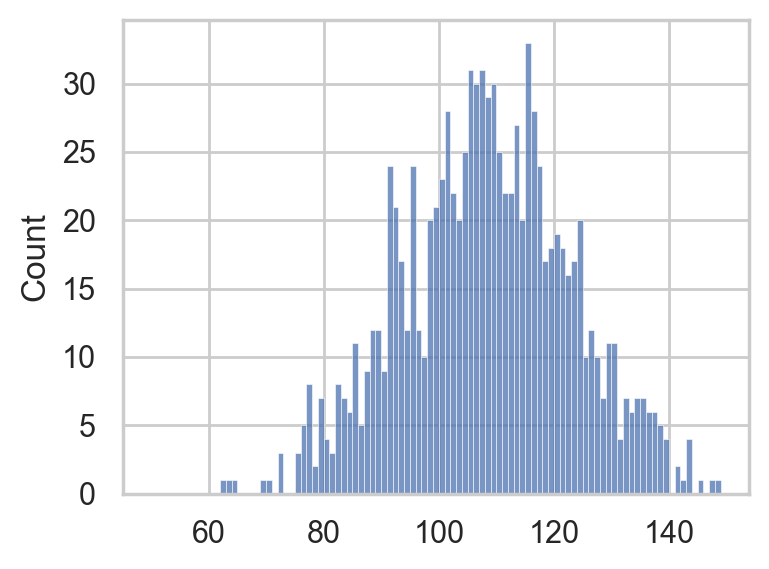

In [4]:
import numpy as np
np.random.seed(43)
n = 1000
population = rvX.rvs(n)
sns.histplot(population, bins=range(50, 150, 1))
savefig(plt.gcf(), 'figures/histplot_iqs_pop_vFR.png')

### Exemple de scores de QI

Considérez l'ensemble de données suivant,
qui comprend les scores de QI de 30 élèves.
Les scores de QI sont consignés dans la liste suivante.

In [5]:
échantillon = [95.7, 100.1, 95.3, 100.7, 123.5, 119.4,
               84.4, 109.6, 108.7, 84.7, 111.0, 92.1,
               138.4, 105.2, 97.5, 115.9, 104.4, 105.6,
               104.8, 110.8, 93.8, 106.6, 71.3, 130.6,
               125.7, 130.2, 101.2, 109.0, 103.8, 96.7]

In [6]:
n = len(échantillon)
n

30

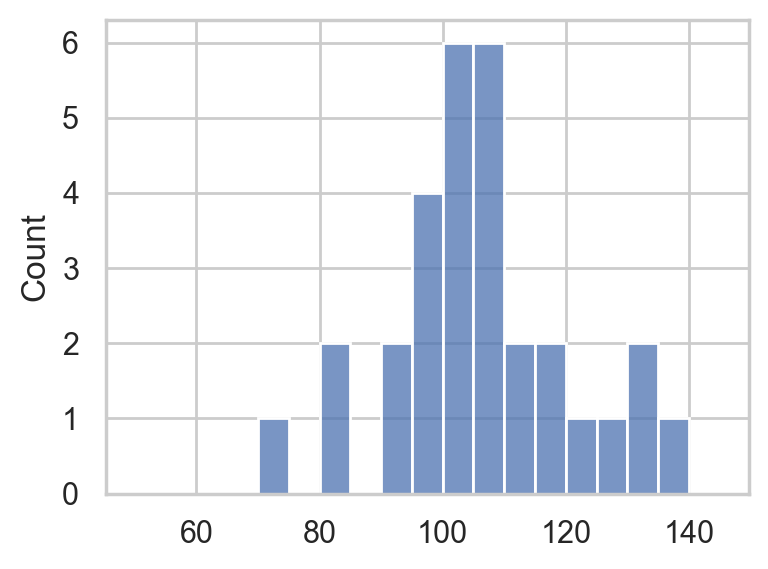

In [7]:
import seaborn as sns
sns.histplot(échantillon, bins=range(50, 150, 5))
savefig(plt.gcf(), 'figures/histplot_iqs_vFR.png')

### Statistical inference tasks

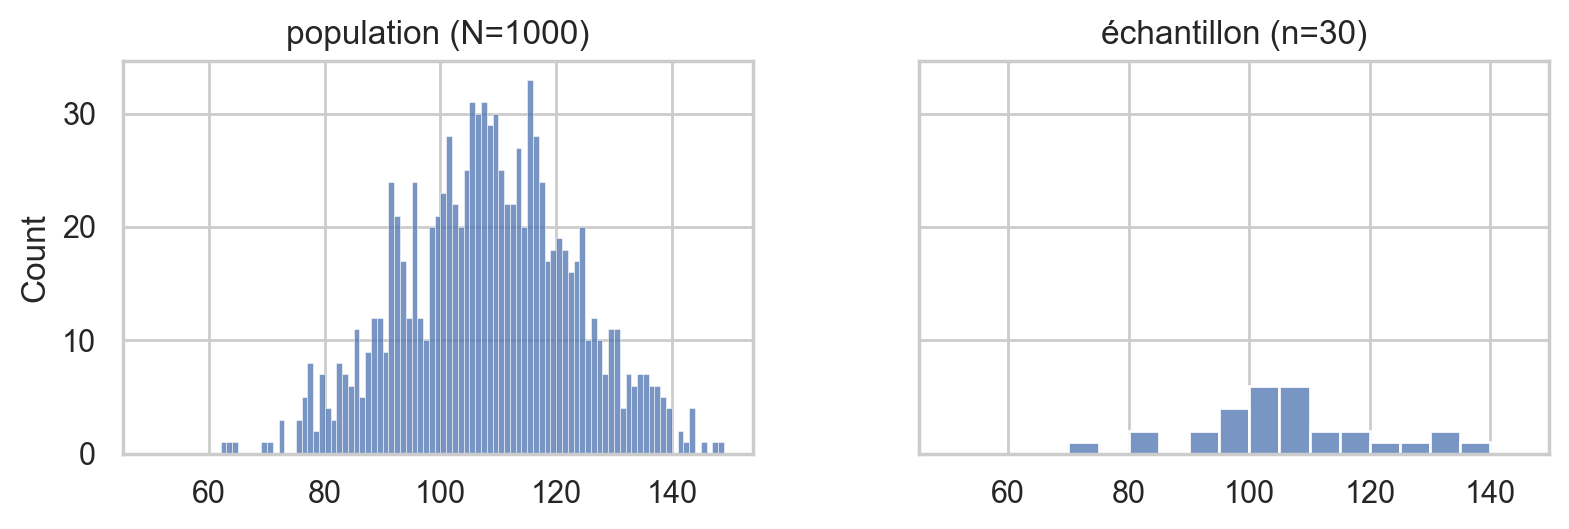

In [8]:
with plt.rc_context({'figure.figsize': (8, 2.8)}):
    fig, (ax_1, ax_2) = plt.subplots(1, 2, sharey=True)
    sns.histplot(population, bins=np.arange(50, 150, 1), ax=ax_1)
    ax_1.set_title('population (N=1000)')
    sns.histplot(échantillon, bins=range(50, 150, 5), ax=ax_2)
    ax_2.set_title('échantillon (n=30)')
    savefig(plt.gcf(), 'figures/histplots_iqs_pop_and_sample_vFR.png', w_pad=5)

## Estimation (TASK1)

### Moyenne de l'échantillon

In [9]:
def moyenne(xs):
    return sum(xs) / len(xs)

In [10]:
moyenne(échantillon)

105.89

La moyenne de l'échantillon est un estimation pour la moyenne de la population $\mu$.

### Écart-type de l'échantillion

Voici un autre estimateur:
le écart-type $s_{\mathbf{x}} = \tt{std}(\mathbf{x}) = \sqrt{ \frac{1}{n-1}\sum_{i=1}^n (x_i-\overline{\mathbf{x}})^2 }$.

In [11]:
import numpy as np

def std(xs):
    n = len(xs)
    xbar = moyenne(xs)
    s_2 = sum([(xi - xbar) ** 2 for xi in xs])
    return np.sqrt(s_2 / (n - 1))

In [12]:
std(échantillon)

14.658229417469641

L'écart type de l'échantillon est une estimation de l'écart type de la population $\sigma$.

## Distribution d’échantillonnage de le moyenne

Regardons dix échantillons de taille $n=30$ pris au hasard de la population.

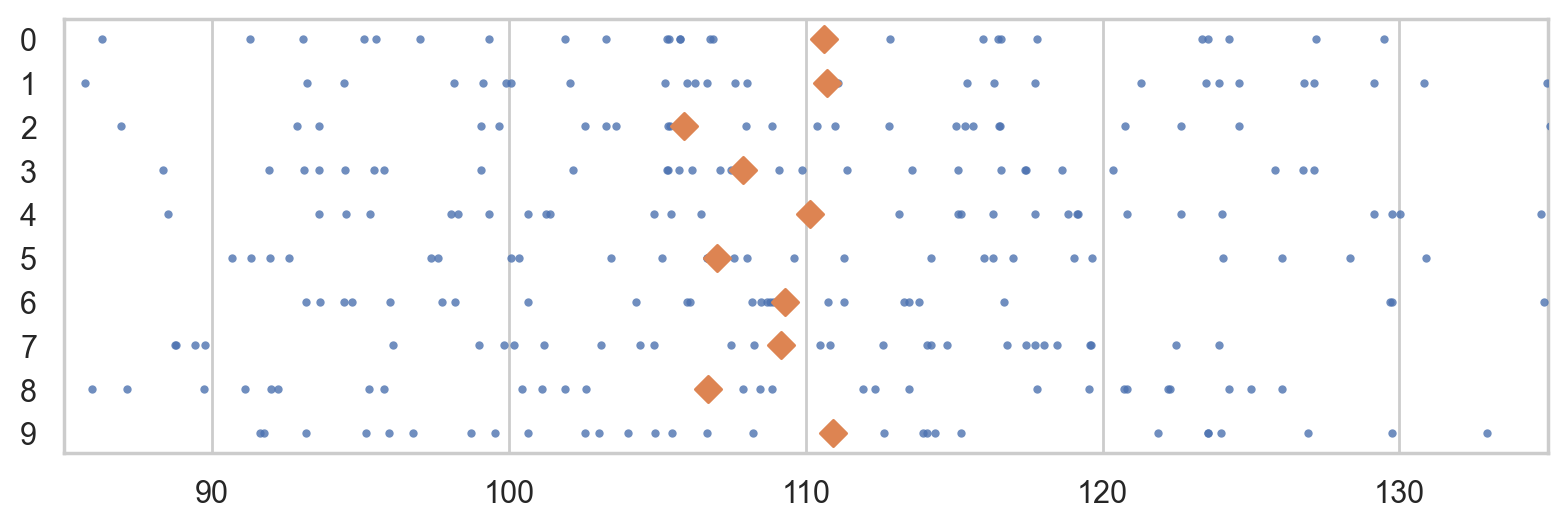

In [13]:
np.random.seed(5)
rsamples = []
for i in range(10):
    rsample = np.random.choice(population, n)
    rsamples.append(rsample)


with plt.rc_context({'figure.figsize': (8, 2.8)}):
    ax = sns.stripplot(rsamples, orient='h', s=3, color='C0', alpha=0.8, jitter=0)
    ax.set_xlim([85, 135])
    for i, rsample in enumerate(rsamples):
        rmean = np.mean(rsample)
        ax.scatter(rmean, i, marker='D', s=45, color='C1', zorder=10)
    savefig(plt.gcf(), 'figures/samples_from_population_n30_vFR.png')

Maintenant 5000 échantillons.

In [14]:
np.random.seed(6)
rmoyennes = []
for i in range(5000):
    rsample = np.random.choice(population, n)
    rmoyenne = moyenne(rsample)
    rmoyennes.append(rmoyenne)

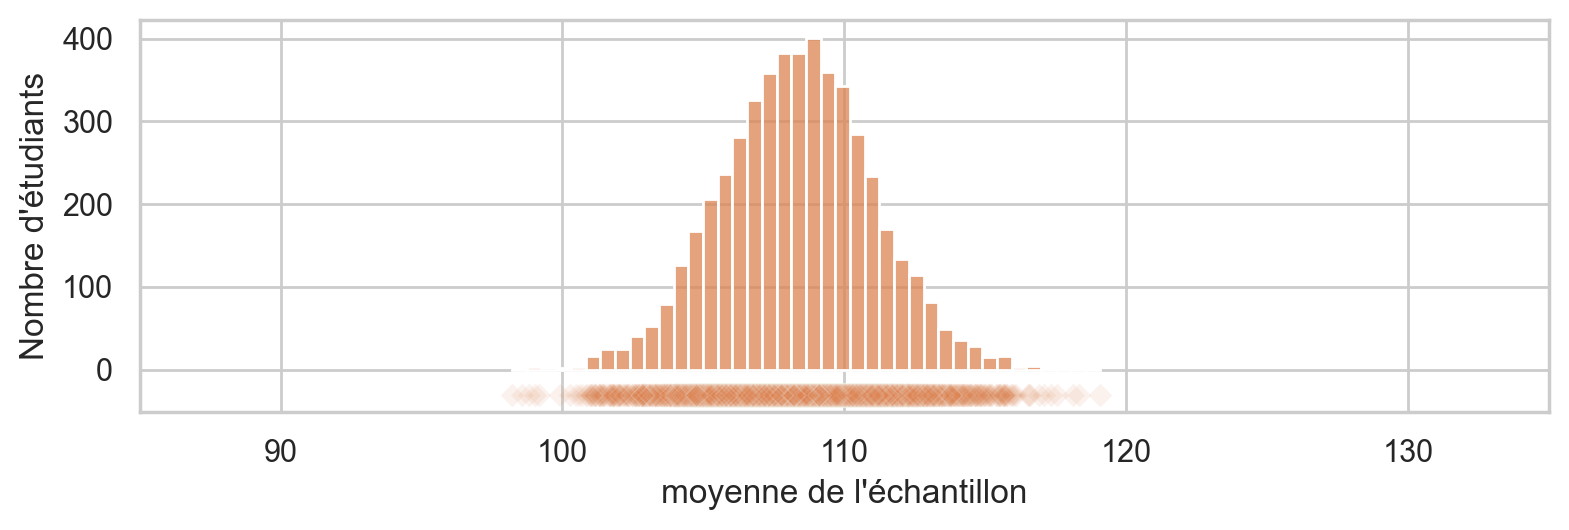

In [15]:
with plt.rc_context({'figure.figsize': (8, 2.8)}):
    ax = sns.histplot(rmoyennes, color='C1', bins=40)
    ax.set_xlim([85, 135])
    sns.scatterplot(x=rmoyennes, y=-30, color='C1', marker='D', alpha=0.1, ax=ax)
    ax.set_ylabel("Nombre d'étudiants")
    ax.set_xlabel("moyenne de l'échantillon")
    savefig(plt.gcf(), 'figures/true_sampling_dist_mean_population_n30_vFR.png')

## Bootstrap estimation

Générez 5000 échantillons bootstrap (échantillonnage avec remplacement) à partir de l'échantillon « échantillon ».

On va utiliser les échantillons bootstrap pour approximer la distribution d'échantillonnage de la moyenne.

In [16]:
np.random.seed(46)
bmoyennes = []
for i in range(5000):
    bsample = np.random.choice(échantillon, n)
    bmoyenne = moyenne(bsample)
    bmoyennes.append(bmoyenne)

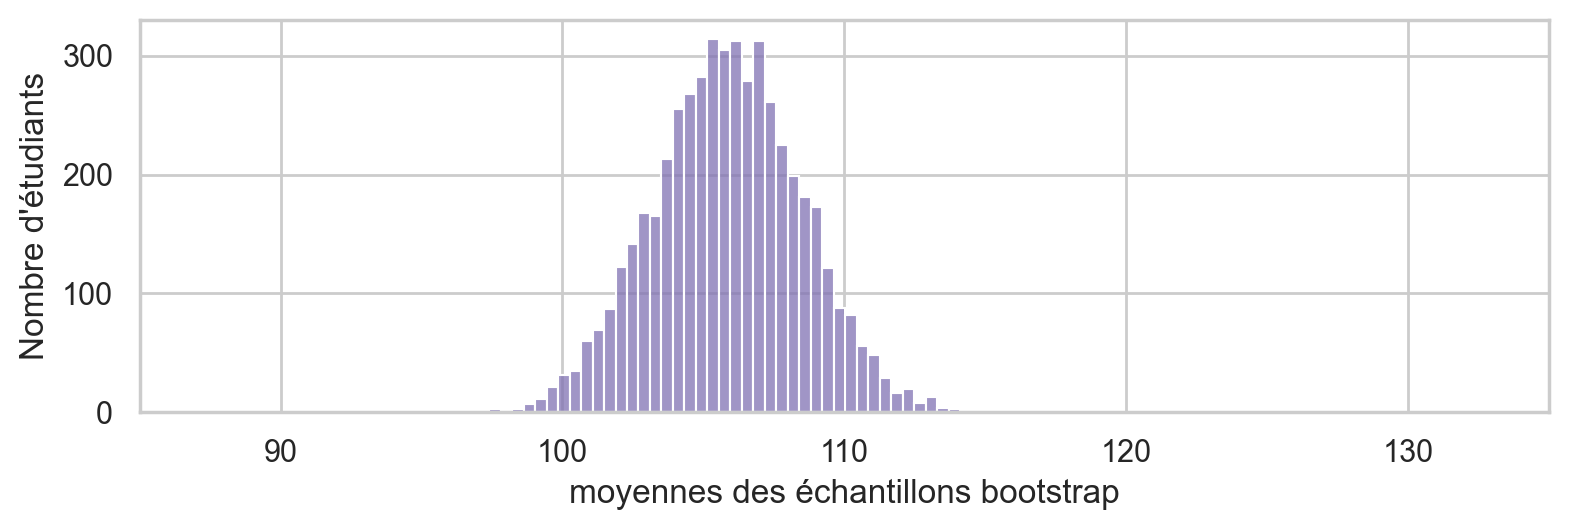

In [17]:
with plt.rc_context({'figure.figsize': (8, 2.8)}):
    ax = sns.histplot(bmoyennes, color='C4')
    ax.set_xlim([85, 135])
    ax.set_ylim([0, 330])
    ax.set_ylabel("Nombre d'étudiants")
    ax.set_xlabel("moyennes des échantillons bootstrap")
    savefig(plt.gcf(), 'figures/bootstrap_dist_mean_iqs_vFR.png')

In [18]:
ic90 = np.percentile(bmoyennes, [5, 95])
ic90.round(2)

array([101.52, 110.16])

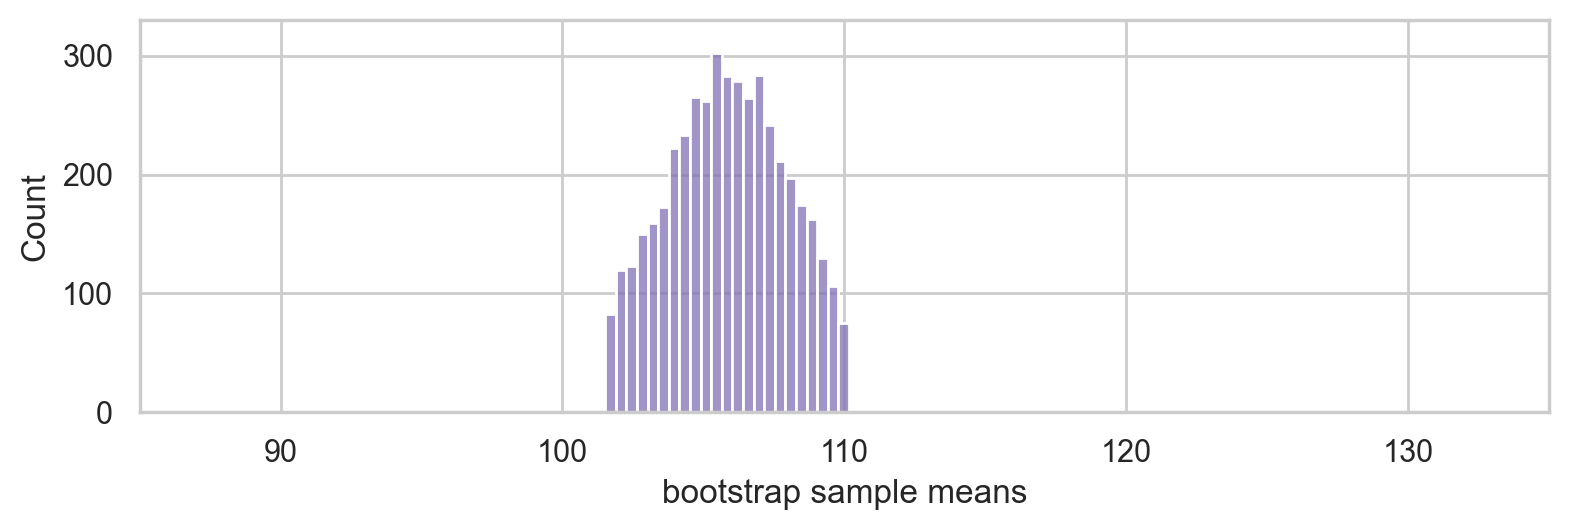

In [19]:
bulk = [x for x in bmoyennes if x > ic90[0] and x < ic90[1]]
with plt.rc_context({'figure.figsize': (8, 2.8)}):
    ax = sns.histplot(bulk, color='C4')
    ax.set_xlim([85, 135])
    ax.set_ylim([0, 330])
    ax.set_ylabel('Count')
    ax.set_xlabel('bootstrap sample means')
    savefig(plt.gcf(), 'figures/bootstrap_dist_mean_iqs_ci_vFR.png')

#### Méthode alternative : utiliser las formule analytiques

La méthode statistique classique pour calculer un intervalle de confiance
comporte les étapes suivantes.

In [20]:
xbar = moyenne(échantillon)
xbar

105.89

In [21]:
stddev = std(échantillon)
stddev

14.658229417469641

In [22]:
sehat = stddev / np.sqrt(n)
sehat

2.6762143016779776

In [23]:
from scipy.stats import t as tdist
t_l = tdist(df=29).ppf(0.05)
t_u = tdist(df=29).ppf(0.95)
(t_l, t_u)

(-1.6991270265334977, 1.6991270265334972)

In [24]:
[xbar + t_l * sehat, xbar + t_u * sehat]

[101.34277195122348, 110.43722804877652]

#### Alternative 2: utilisant un fonction prédéfinie

In [25]:
from ministats import ci_mean
ci_mean(échantillon, alpha=0.1)

[101.34277195122348, 110.43722804877652]

In [26]:
np.random.seed(46)
from ministats import ci_mean
ci_mean(échantillon, alpha=0.1, method='b')

[101.51616666666666, 110.16350000000001]

In [27]:
%psource ci_mean

def ci_mean(sample, alpha=0.1, method="a"):
    """
    Compute confidence interval for the population mean.
    - method="a" analytical approx. based on Student's t-dist
    - method="b" approx. based on bootstrap estimation
    """
    assert method in ["a", "b"]
    if method == "a":        # analytical approximation
        from scipy.stats import t as tdist
        n = len(sample)
        xbar = np.mean(sample)
        sehat = np.std(sample, ddof=1) / np.sqrt(n)
        t_l = tdist(df=n-1).ppf(alpha/2)
        t_u = tdist(df=n-1).ppf(1-alpha/2)
        return [xbar + t_l*sehat, xbar + t_u*sehat]
    elif method == "b":      # bootstrap estimation
        xbars_boot = gen_boot_dist(sample, estfunc=mean)
        return [np.quantile(xbars_boot, alpha/2),
                np.quantile(xbars_boot, 1-alpha/2)]


#### Alternative 3: en utilisant scipy

In [28]:
from scipy.stats import bootstrap
res = bootstrap([échantillon], np.mean, confidence_level=0.9)
# [res.low, res.high]
bic90 = res.confidence_interval
[bic90.low, bic90.high]

[101.65580265968799, 110.3411373248789]

## Conclusion

## Liens

- Des bons talks sur les méthodes de rééchantillonnage:
  - [Statistiques pour Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) par Jake Vanderplas
  - [There's Only One Test](https://www.youtube.com/watch?v=S41zQEshs5k) par Allen B. Downey
- [Python tutorial](https://nobsstats.com/tutorials/python_tutorial.html)
- Blog posts:
  - [Outline de le stats curriculum research](https://minireference.com/blog/fixing-le-introductory-statistiques-curriculum/)
  - [Book proposal](https://minireference.com/blog/no-bullshit-guide-à-statistiques-progress-update/)
  - [Stats survey results](https://minireference.com/blog/what-stats-do-people-want-à-learn/)
  - [Python coding skills pour statistiques](https://minireference.com/blog/python-pour-stats/)
  - [Sales pitch about why you should learn statistics](https://minireference.com/blog/noBSstats-sales-pitch/)
  - [No Bullshit Guide to Statistics prerelease](https://minireference.com/blog/noBSstats-prerelease/)
- Le site web du livre [noBSstats.com](https://nobsstats.com/intro.html): contient tous les notebooks du livre.


## CUT MATERIAL

In [29]:
%pip install --quiet qrcode

Note: you may need to restart the kernel to use updated packages.


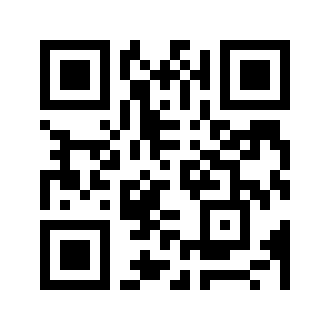

In [30]:
import qrcode
img = qrcode.make('https://is.gd/TDoct25')
img.save('figures/QRcode_is_gd_TDoct25.png')
img

### Inférence statistique « à l'oeil »

Déplacez les sliders pour choisir les paramètres du modèle qui correspondent le mieux aux données.


In [31]:
import numpy as np
from scipy.stats import norm
from ipywidgets import interact


def plot_pop_and_sample(mu, sigma):
    ax = sns.histplot(x=échantillon, stat='density', bins=range(50, 150, 5), label='data')
    rv_X = norm(mu, sigma)
    xs = np.linspace(50, 150, 1000)
    f_Xs = rv_X.pdf(xs)
    sns.lineplot(x=xs, y=f_Xs, ax=ax, c='C0', label='model')
    print(f'modèle pour la population: X ~ N(mu={mu}, sigma={sigma})')

interact(plot_pop_and_sample, mu=(50, 150, 1), sigma=(3, 40, 1));

interactive(children=(IntSlider(value=100, description='mu', max=150, min=50), IntSlider(value=21, description…